<h2>IMPORTS</h2>

In [1]:
import os
import sys
import keras
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import deque
from IPython.display import clear_output
from keras import layers, models, optimizers

buildPath = os.path.abspath(os.path.join("..", "buildwin", "Release"))
sys.path.insert(0, buildPath)

try:
    import snake_env
    print("Module imported successfully")
except Exception as e:
    print(f"Import failed: {e}")
    print(f"Looking in: {buildPath}")
    raise

Module imported successfully


<h2>PARAMETERS & HYPERPARAMETERS</h2>

In [2]:
LOAD_MODEL = False
LOAD_MODEL_PATH = "models/dqn_model_episode_200.keras"

LEARNING_RATE = 0.00001
BATCH_SIZE = 1000
EPOCHS = 200
MEMORY_SIZE = 100000
EPSILON = 1.0
EPSILON_DECAY = 0.975
MIN_EPSILON = 0.05
GAMMA = 0.95
TARGET_UPDATE_FREQ = 20
TRAINING_THRESHOLD = 1000
TRAINING_STEPS = 8

WIDTH = 10
HEIGHT = 10


episode = 0

lrScheduler = keras.callbacks.ReduceLROnPlateau(
    monitor='loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

replayBuffer = deque(maxlen=MEMORY_SIZE)


<h2>GAME WRAPPER</H2>

In [3]:
class SnakeEnv():
    def __init__(self):
        self.env = snake_env.Neural(WIDTH, HEIGHT)
    
    def reset(self):
        state = self.env.reset()
        return np.array(state.board, dtype=np.float32)
    
    def step(self, action):
        state = self.env.step(action)
        return np.array(state.ob.board, dtype=np.float32), state.reward, state.done

<h2>NEURAL NETWORK</h2>

In [4]:
if not LOAD_MODEL:
    def build_model(inputShape, neuronCount, hiddenLayers, outputShape):
        model = models.Sequential()
        model.add(layers.Input(shape=(inputShape,)))
        for i in range(hiddenLayers):
            model.add(layers.Dense(neuronCount, activation='relu'))
            if neuronCount > 4:
                neuronCount = neuronCount // 2
        model.add(layers.Dense(outputShape))
        return model

    model = build_model(11, 128, 3, 3)
    model.compile(optimizer=optimizers.Adam(learning_rate=LEARNING_RATE, clipnorm=1.0), loss=keras.losses.Huber(delta=1.0))
    model.summary()
else:
    try:
        model = keras.models.load_model(LOAD_MODEL_PATH)
        print(f"Model loaded from {LOAD_MODEL_PATH}")
        model.summary()
    except Exception as e:
        print(f"Failed to load model from {LOAD_MODEL_PATH}: {e}")
        raise

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,971 (46.76 KB)

 Trainable params: 11,971 (46.76 KB)

 Non-trainable params: 0 (0.00 B)

<h2>EXPERIENCE COLLECTION</h2>

In [5]:
def collectExperience(batch):
    env = SnakeEnv()
    localModel = keras.models.clone_model(model)
    localModel.set_weights(model.get_weights())
    state = env.reset()
    totalReward = 0
    localExperiences = deque(maxlen=batch)
    doneReset = False
    steps = 0
    
    for i in range(batch):
        if np.random.rand() < EPSILON:
            action = np.random.randint(0, 3)
        else:
            # Reshape state to (1, 11) for prediction
            qValues = model.predict(state.reshape(1, -1), verbose=0)
            action = np.argmax(qValues)
        
        if doneReset:
            steps = 0
            doneReset = False
        
        steps += 1
        if steps % 10 == 0:
            totalReward -= 1
        
        nextState, reward, done = env.step(action)
        if done:
            reward -= 5
        
        localExperiences.append((state, action, reward, nextState, done))
        totalReward += reward
        state = nextState
        
        if done:
            doneReset = True
            state = env.reset()
    
    return localExperiences, totalReward


def getExperiences(batch):
    experiences, totalReward = collectExperience(batch)
    for exp in experiences:
        replayBuffer.append(exp)
    return totalReward

## VISUALIZATION FUNCTIONS

In [6]:
def plot_training_statistics(episode, episodeRewards, episodeLosses, epsilon, replayBufferSize, 
                            windowSize=30, figsize=(15, 10)):
    plt.clf()  
    fig = plt.figure(figsize=figsize)
    
    gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)
    
    ax1 = fig.add_subplot(gs[0, 0])
    if len(episodeRewards) > 0:
        ax1.plot(episodeRewards, alpha=0.8, color='dodgerblue', linewidth=2)
        ax1.set_title('Episode Rewards (Raw)', fontsize=13, fontweight='bold')
        ax1.set_xlabel('Episode', fontsize=11)
        ax1.set_ylabel('Total Reward', fontsize=11)
        ax1.grid(True, alpha=0.3, linestyle='--')
        ax1.axhline(y=0, color='red', linestyle='--', alpha=0.7, linewidth=2)
    else:
        ax1.text(0.5, 0.5, 'Waiting for data...', ha='center', va='center', 
                transform=ax1.transAxes, fontsize=12)
        ax1.set_title('Episode Rewards (Raw)', fontsize=13, fontweight='bold')
    
    ax2 = fig.add_subplot(gs[0, 1])
    if len(episodeRewards) >= windowSize:
        movingAvg = pd.Series(episodeRewards).rolling(window=windowSize).mean()
        ax2.plot(movingAvg, color='darkblue', linewidth=3)
        ax2.fill_between(range(len(movingAvg)), movingAvg, alpha=0.3, color='blue')
        ax2.set_title(f'Moving Average Rewards (window={windowSize})', fontsize=13, fontweight='bold')
        ax2.set_xlabel('Episode', fontsize=11)
        ax2.set_ylabel('Average Reward', fontsize=11)
        ax2.grid(True, alpha=0.3, linestyle='--')
        ax2.axhline(y=0, color='red', linestyle='--', alpha=0.7, linewidth=2)
    else:
        ax2.text(0.5, 0.5, f'Need {windowSize} episodes\nfor moving average\n({len(episodeRewards)}/{windowSize})', 
                ha='center', va='center', transform=ax2.transAxes, fontsize=12)
        ax2.set_title(f'Moving Average Rewards (window={windowSize})', fontsize=13, fontweight='bold')
    
    ax3 = fig.add_subplot(gs[1, 0])
    if len(episodeLosses) > 0:
        ax3.plot(episodeLosses, color='darkorange', linewidth=2.5)
        ax3.set_title('Training Loss per Episode', fontsize=13, fontweight='bold')
        ax3.set_xlabel('Episode', fontsize=11)
        ax3.set_ylabel('Loss', fontsize=11)
        ax3.grid(True, alpha=0.3, linestyle='--')
        ax3.set_yscale('log') 
    else:
        ax3.text(0.5, 0.5, 'Waiting for training...', ha='center', va='center', 
                transform=ax3.transAxes, fontsize=12)
        ax3.set_title('Training Loss per Episode', fontsize=13, fontweight='bold')
    
    ax4 = fig.add_subplot(gs[1, 1])
    epsilonHistory = [EPSILON * (EPSILON_DECAY ** i) for i in range(episode + 1)]
    epsilonHistory = [max(MIN_EPSILON, e) for e in epsilonHistory]
    ax4.plot(epsilonHistory, color='forestgreen', linewidth=3)
    ax4.set_title('Exploration Rate (Epsilon)', fontsize=13, fontweight='bold')
    ax4.set_xlabel('Episode', fontsize=11)
    ax4.set_ylabel('Epsilon', fontsize=11)
    ax4.grid(True, alpha=0.3, linestyle='--')
    ax4.set_ylim([-0.05, 1.05])
    
    ax5 = fig.add_subplot(gs[2, 0])
    if len(episodeRewards) > 0:
        ax5.hist(episodeRewards, bins=30, color='mediumpurple', alpha=0.7, edgecolor='black', linewidth=1.2)
        ax5.axvline(np.mean(episodeRewards), color='red', linestyle='--', 
                   linewidth=3, label=f'Mean: {np.mean(episodeRewards):.2f}')
        ax5.set_title('Reward Distribution', fontsize=13, fontweight='bold')
        ax5.set_xlabel('Reward', fontsize=11)
        ax5.set_ylabel('Frequency', fontsize=11)
        ax5.legend(fontsize=10)
        ax5.grid(True, alpha=0.3, linestyle='--')
    else:
        ax5.text(0.5, 0.5, 'Waiting for data...', ha='center', va='center', 
                transform=ax5.transAxes, fontsize=12)
        ax5.set_title('Reward Distribution', fontsize=13, fontweight='bold')
    
    # 6. Statistics Summary (Text)
    ax6 = fig.add_subplot(gs[2, 1])
    ax6.axis('off')
    
    if len(episodeRewards) > 0:
        latestLoss = episodeLosses[-1] if episodeLosses else 0
        meanLoss = np.mean(episodeLosses) if episodeLosses else 0
        
        statsText = f"""
        TRAINING STATISTICS
        {'='*40}
        
        Current Episode: {episode + 1}
        
        REWARDS:
        • Latest Reward: {episodeRewards[-1]:.2f}
        • Mean Reward: {np.mean(episodeRewards):.2f}
        • Max Reward: {np.max(episodeRewards):.2f}
        • Min Reward: {np.min(episodeRewards):.2f}
        
        LOSS:
        • Latest Loss: {latestLoss:.6f}
        • Mean Loss: {meanLoss:.6f}
        
        EXPLORATION:
        • Current Epsilon: {epsilon:.4f}
        • Decay Rate: {EPSILON_DECAY}
        
        MEMORY:
        • Replay Buffer: {replayBufferSize}/{MEMORY_SIZE}
        • Buffer Usage: {(replayBufferSize/MEMORY_SIZE)*100:.1f}%
        """
        ax6.text(0.1, 0.5, statsText, fontsize=11, family='monospace',
                verticalalignment='center', transform=ax6.transAxes)
    
    plt.suptitle(f'DQN Training Progress - Episode {episode + 1}', 
                fontsize=16, fontweight='bold', y=0.98)
    
    plt.tight_layout()
    plt.draw()
    plt.pause(0.001)
    
    return fig


# plot_training_statistics(episode, episodeRewards, episodeLosses, EPSILON, len(replayBuffer))

<h2>DQN TRAINING</h2>

Episode 5 Summary:
  Reward: -218.00
  Avg Reward (last 30): -261.25
  Avg Loss: 0.101194
  Epsilon: 0.904
  Replay Buffer: 4000/100000


<Figure size 640x480 with 0 Axes>

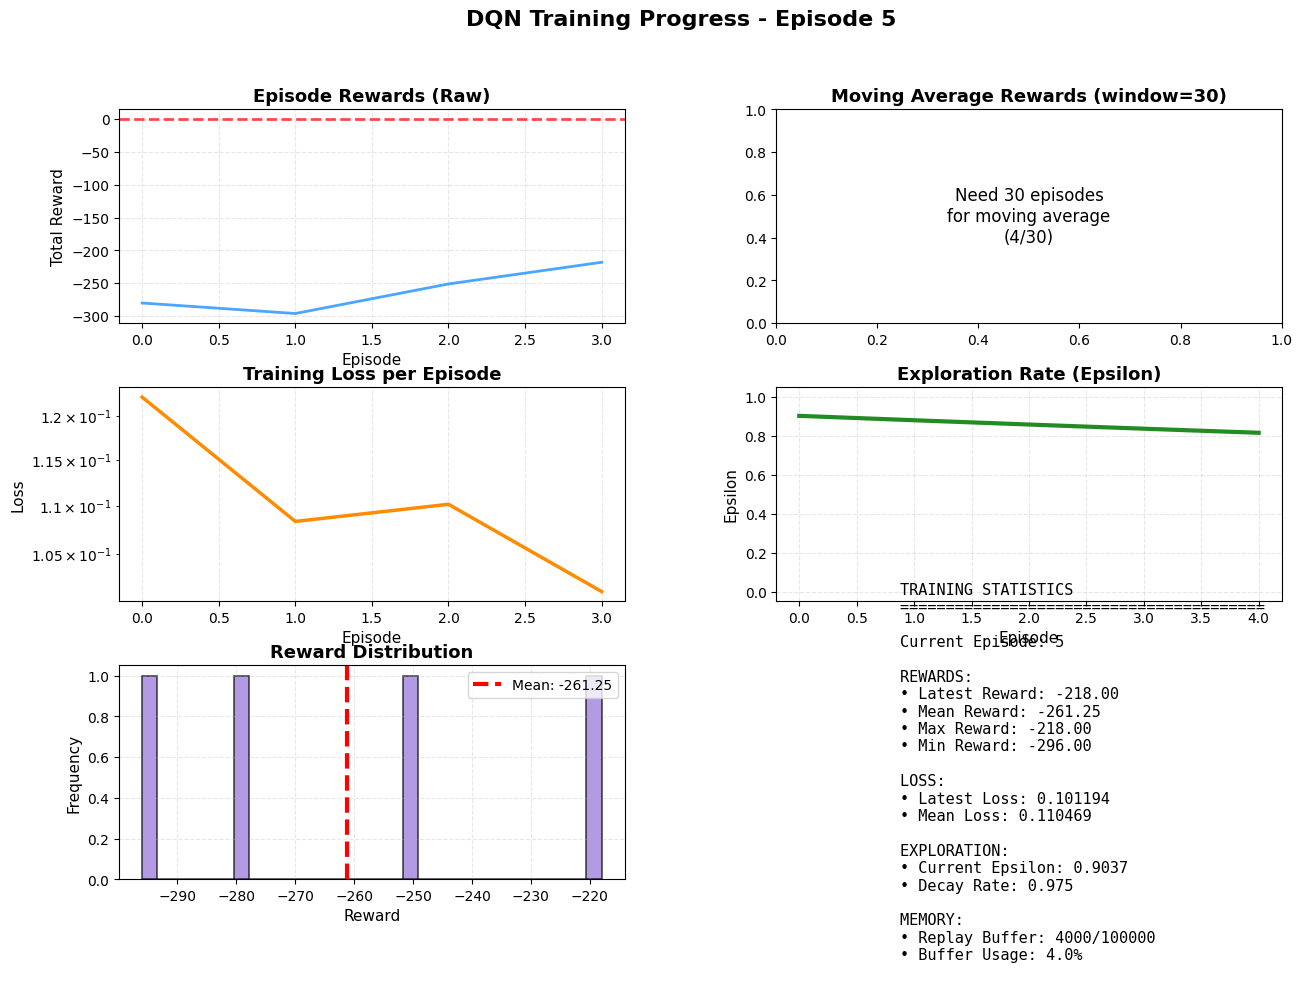

KeyboardInterrupt: 

In [7]:
episodeRewards = []
episodeLosses = []

targetModel = keras.models.clone_model(model)
targetModel.set_weights(model.get_weights())

for episode in range(EPOCHS):
    epRewards = getExperiences(BATCH_SIZE)
    episode += 1
    epLosses = []
    
    if len(replayBuffer) >= TRAINING_THRESHOLD:
        for _ in range(TRAINING_STEPS):
            minibatch = random.sample(list(replayBuffer), min(BATCH_SIZE, len(replayBuffer)))
            
            initialStates = np.array([exp[0] for exp in minibatch], dtype=np.float32)
            nextStates = np.array([exp[3] for exp in minibatch], dtype=np.float32)
            
            targetQ = model.predict(initialStates, verbose=0)
            nextQO = model.predict(nextStates, verbose=0)
            nextQ = targetModel.predict(nextStates, verbose=0)
            
            for i, (state, action, reward, nextState, done) in enumerate(minibatch):
                if done:
                    targetQ[i][action] = reward
                else:
                    nextAction = np.argmax(nextQO[i])
                    targetQ[i][action] = reward + GAMMA * nextQ[i][nextAction]
            
            history = model.fit(initialStates, targetQ, epochs=1, verbose=0, callbacks=[lrScheduler])
            epLosses.append(history.history['loss'][0])
        
        EPSILON = max(MIN_EPSILON, EPSILON * EPSILON_DECAY)
        
        episodeRewards.append(epRewards)
        if epLosses:
            episodeLosses.append(np.mean(epLosses))
        
        avgReward = np.mean(episodeRewards[-30:]) if len(episodeRewards) >= 30 else np.mean(episodeRewards)
        avgLoss = np.mean(epLosses) if epLosses else 0
        clear_output(True)
        print(f"Episode {episode + 1} Summary:")
        print(f"  Reward: {epRewards:.2f}")
        print(f"  Avg Reward (last 30): {avgReward:.2f}")
        print(f"  Avg Loss: {avgLoss:.6f}")
        print(f"  Epsilon: {EPSILON:.3f}")
        print(f"  Replay Buffer: {len(replayBuffer)}/{replayBuffer.maxlen}")
        
        plot_training_statistics(episode, episodeRewards, episodeLosses, EPSILON, len(replayBuffer))
        
        if episode % TARGET_UPDATE_FREQ == 0:
            targetModel.set_weights(model.get_weights())
        
        if episode % 20 == 0:
            model.save(f"models/dqn_model_episode_{episode}.keras")
            print(f"Model saved at episode {episode}")

## MODEL TESTING

In [ ]:
def test_model(modelPath, numSimulations=10, maxSteps=10000):

    print(f"Loading model from: {modelPath}")
    testModel = keras.models.load_model(modelPath)
    

    rewards = []
    stepsPerGame = []
    fruitsEaten = []
    

    for sim in range(numSimulations):
        env = SnakeEnv()
        state = env.reset()
        totalReward = 0
        steps = 0
        fruits = 0
        
        print(f"\nSimulation {sim + 1}/{numSimulations}...")
        
        while steps < maxSteps:
            qValues = testModel.predict(state.reshape(1, -1), verbose=0)
            action = np.argmax(qValues)
            
            nextState, reward, done = env.step(action)
            
            totalReward += reward
            steps += 1
            if reward > 0:  
                fruits += 1
            
            state = nextState
            
            if done:
                break
        
        rewards.append(totalReward)
        stepsPerGame.append(steps)
        fruitsEaten.append(fruits)
        
        print(f"  Result: Reward={totalReward:.2f}, Steps={steps}, Fruits={fruits}")
    
    stats = {
        'mean_reward': np.mean(rewards),
        'std_reward': np.std(rewards),
        'min_reward': np.min(rewards),
        'max_reward': np.max(rewards),
        'mean_steps': np.mean(stepsPerGame),
        'std_steps': np.std(stepsPerGame),
        'mean_fruits': np.mean(fruitsEaten),
        'max_fruits': np.max(fruitsEaten),
        'total_fruits': np.sum(fruitsEaten),
        'rewards': rewards,
        'steps': stepsPerGame,
        'fruits': fruitsEaten
    }
    
    print("\n" + "="*60)
    print("TEST RESULTS SUMMARY")
    print("="*60)
    print(f"Number of Simulations: {numSimulations}")
    print(f"\nREWARDS:")
    print(f"  Mean:   {stats['mean_reward']:.2f} ± {stats['std_reward']:.2f}")
    print(f"  Min:    {stats['min_reward']:.2f}")
    print(f"  Max:    {stats['max_reward']:.2f}")
    print(f"\nSTEPS (Game Length):")
    print(f"  Mean:   {stats['mean_steps']:.2f} ± {stats['std_steps']:.2f}")
    print(f"\nFRUITS EATEN:")
    print(f"  Mean:   {stats['mean_fruits']:.2f}")
    print(f"  Max:    {stats['max_fruits']}")
    print(f"  Total:  {stats['total_fruits']}")
    print("="*60)
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    axes[0].bar(range(1, numSimulations + 1), rewards, color='skyblue', edgecolor='black')
    axes[0].axhline(stats['mean_reward'], color='red', linestyle='--', linewidth=2, label=f"Mean: {stats['mean_reward']:.2f}")
    axes[0].set_title('Rewards per Simulation', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Simulation')
    axes[0].set_ylabel('Total Reward')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    axes[1].bar(range(1, numSimulations + 1), stepsPerGame, color='lightgreen', edgecolor='black')
    axes[1].axhline(stats['mean_steps'], color='red', linestyle='--', linewidth=2, label=f"Mean: {stats['mean_steps']:.2f}")
    axes[1].set_title('Steps per Simulation', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Simulation')
    axes[1].set_ylabel('Steps')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    axes[2].bar(range(1, numSimulations + 1), fruitsEaten, color='orange', edgecolor='black')
    axes[2].axhline(stats['mean_fruits'], color='red', linestyle='--', linewidth=2, label=f"Mean: {stats['mean_fruits']:.2f}")
    axes[2].set_title('Fruits Eaten per Simulation', fontsize=12, fontweight='bold')
    axes[2].set_xlabel('Simulation')
    axes[2].set_ylabel('Fruits')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return stats


def compare_models(modelPath1, modelPath2, numSimulations=10, maxSteps=10000, 
                   model1Name="Model 1", model2Name="Model 2"):
    """
    Compare two trained models side-by-side.
    
    Parameters:
    - modelPath1: Path to first model
    - modelPath2: Path to second model
    - numSimulations: Number of games to play for each model
    - maxSteps: Maximum steps per game
    - model1Name: Display name for first model
    - model2Name: Display name for second model
    
    Returns:
    - Dictionary with comparison statistics
    """
    print("="*80)
    print(f"COMPARING MODELS")
    print("="*80)
    print(f"\nModel 1: {model1Name}")
    print(f"Path: {modelPath1}")
    print(f"\nModel 2: {model2Name}")
    print(f"Path: {modelPath2}")
    print("\n" + "="*80)
    
    print(f"\n{'='*80}")
    print(f"TESTING {model1Name.upper()}")
    print(f"{'='*80}")
    stats1 = test_model(modelPath1, numSimulations, maxSteps)
    
    print(f"\n{'='*80}")
    print(f"TESTING {model2Name.upper()}")
    print(f"{'='*80}")
    stats2 = test_model(modelPath2, numSimulations, maxSteps)
    
    fig = plt.figure(figsize=(18, 12))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    
    ax1 = fig.add_subplot(gs[0, 0])
    x = np.arange(numSimulations)
    width = 0.35
    ax1.bar(x - width/2, stats1['rewards'], width, label=model1Name, color='skyblue', edgecolor='black', alpha=0.8)
    ax1.bar(x + width/2, stats2['rewards'], width, label=model2Name, color='lightcoral', edgecolor='black', alpha=0.8)
    ax1.set_title('Rewards Comparison', fontsize=13, fontweight='bold')
    ax1.set_xlabel('Simulation')
    ax1.set_ylabel('Total Reward')
    ax1.legend()
    ax1.grid(True, alpha=0.3, axis='y')
    
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.bar(x - width/2, stats1['steps'], width, label=model1Name, color='lightgreen', edgecolor='black', alpha=0.8)
    ax2.bar(x + width/2, stats2['steps'], width, label=model2Name, color='orange', edgecolor='black', alpha=0.8)
    ax2.set_title('Steps Comparison', fontsize=13, fontweight='bold')
    ax2.set_xlabel('Simulation')
    ax2.set_ylabel('Steps')
    ax2.legend()
    ax2.grid(True, alpha=0.3, axis='y')
    
    ax3 = fig.add_subplot(gs[0, 2])
    ax3.bar(x - width/2, stats1['fruits'], width, label=model1Name, color='mediumpurple', edgecolor='black', alpha=0.8)
    ax3.bar(x + width/2, stats2['fruits'], width, label=model2Name, color='gold', edgecolor='black', alpha=0.8)
    ax3.set_title('Fruits Eaten Comparison', fontsize=13, fontweight='bold')
    ax3.set_xlabel('Simulation')
    ax3.set_ylabel('Fruits')
    ax3.legend()
    ax3.grid(True, alpha=0.3, axis='y')
    
    ax4 = fig.add_subplot(gs[1, 0])
    boxDataRewards = [stats1['rewards'], stats2['rewards']]
    bp1 = ax4.boxplot(boxDataRewards, labels=[model1Name, model2Name], 
                      patch_artist=True, widths=0.6)
    bp1['boxes'][0].set_facecolor('skyblue')
    bp1['boxes'][1].set_facecolor('lightcoral')
    ax4.set_title('Reward Distribution', fontsize=13, fontweight='bold')
    ax4.set_ylabel('Total Reward')
    ax4.grid(True, alpha=0.3, axis='y')
    
    ax5 = fig.add_subplot(gs[1, 1])
    boxDataSteps = [stats1['steps'], stats2['steps']]
    bp2 = ax5.boxplot(boxDataSteps, labels=[model1Name, model2Name], 
                      patch_artist=True, widths=0.6)
    bp2['boxes'][0].set_facecolor('lightgreen')
    bp2['boxes'][1].set_facecolor('orange')
    ax5.set_title('Steps Distribution', fontsize=13, fontweight='bold')
    ax5.set_ylabel('Steps')
    ax5.grid(True, alpha=0.3, axis='y')
    
    ax6 = fig.add_subplot(gs[1, 2])
    boxDataFruits = [stats1['fruits'], stats2['fruits']]
    bp3 = ax6.boxplot(boxDataFruits, labels=[model1Name, model2Name], 
                      patch_artist=True, widths=0.6)
    bp3['boxes'][0].set_facecolor('mediumpurple')
    bp3['boxes'][1].set_facecolor('gold')
    ax6.set_title('Fruits Distribution', fontsize=13, fontweight='bold')
    ax6.set_ylabel('Fruits')
    ax6.grid(True, alpha=0.3, axis='y')
    
    ax7 = fig.add_subplot(gs[2, 0])
    metrics = ['Mean\nReward', 'Mean\nSteps', 'Mean\nFruits']
    model1Means = [stats1['mean_reward'], stats1['mean_steps'], stats1['mean_fruits']]
    model2Means = [stats2['mean_reward'], stats2['mean_steps'], stats2['mean_fruits']]
    xPos = np.arange(len(metrics))
    ax7.bar(xPos - width/2, model1Means, width, label=model1Name, color='dodgerblue', edgecolor='black', alpha=0.8)
    ax7.bar(xPos + width/2, model2Means, width, label=model2Name, color='crimson', edgecolor='black', alpha=0.8)
    ax7.set_xticks(xPos)
    ax7.set_xticklabels(metrics)
    ax7.set_title('Mean Metrics Comparison', fontsize=13, fontweight='bold')
    ax7.set_ylabel('Value')
    ax7.legend()
    ax7.grid(True, alpha=0.3, axis='y')
    
    ax8 = fig.add_subplot(gs[2, 1])
    model1Wins = sum(1 for i in range(numSimulations) if stats1['fruits'][i] > stats2['fruits'][i])
    model2Wins = sum(1 for i in range(numSimulations) if stats2['fruits'][i] > stats1['fruits'][i])
    ties = numSimulations - model1Wins - model2Wins
    ax8.bar([model1Name, model2Name, 'Ties'], [model1Wins, model2Wins, ties], 
            color=['dodgerblue', 'crimson', 'gray'], edgecolor='black', alpha=0.8)
    ax8.set_title('Win Rate (by Fruits)', fontsize=13, fontweight='bold')
    ax8.set_ylabel('Number of Wins')
    ax8.grid(True, alpha=0.3, axis='y')
    for i, v in enumerate([model1Wins, model2Wins, ties]):
        ax8.text(i, v + 0.1, str(v), ha='center', va='bottom', fontweight='bold')
    
    ax9 = fig.add_subplot(gs[2, 2])
    ax9.axis('off')
    
    rewardDiff = ((stats2['mean_reward'] - stats1['mean_reward']) / abs(stats1['mean_reward']) * 100) if stats1['mean_reward'] != 0 else 0
    fruitsDiff = ((stats2['mean_fruits'] - stats1['mean_fruits']) / stats1['mean_fruits'] * 100) if stats1['mean_fruits'] != 0 else 0
    
    comparisonText = f"""
    COMPARISON SUMMARY
    {'='*35}
    
    {model1Name}:
    • Avg Reward: {stats1['mean_reward']:.2f}
    • Avg Fruits: {stats1['mean_fruits']:.2f}
    • Max Fruits: {stats1['max_fruits']}
    • Win Rate: {(model1Wins/numSimulations)*100:.1f}%
    
    {model2Name}:
    • Avg Reward: {stats2['mean_reward']:.2f}
    • Avg Fruits: {stats2['mean_fruits']:.2f}
    • Max Fruits: {stats2['max_fruits']}
    • Win Rate: {(model2Wins/numSimulations)*100:.1f}%
    
    IMPROVEMENT:
    • Reward: {rewardDiff:+.1f}%
    • Fruits: {fruitsDiff:+.1f}%
    
    WINNER: {model1Name if model1Wins > model2Wins else model2Name if model2Wins > model1Wins else 'TIE'}
    """
    
    ax9.text(0.1, 0.5, comparisonText, fontsize=10, family='monospace',
            verticalalignment='center', transform=ax9.transAxes)
    
    plt.suptitle(f'Model Comparison: {model1Name} vs {model2Name}', 
                fontsize=16, fontweight='bold', y=0.98)
    
    plt.tight_layout()
    plt.show()
    
    return {
        'model1': stats1,
        'model2': stats2,
        'model1_wins': model1Wins,
        'model2_wins': model2Wins,
        'ties': ties,
        'reward_improvement': rewardDiff,
        'fruits_improvement': fruitsDiff
    }

COMPARING MODELS

Model 1: Episode 80
Path: models/v2/dqn_model_episode_100.keras

Model 2: Episode 100
Path: models/dqn_model_episode_140.keras


TESTING EPISODE 80
Loading model from: models/v2/dqn_model_episode_100.keras

Simulation 1/10...
  Result: Reward=160.00, Steps=116, Fruits=16

Simulation 2/10...
  Result: Reward=130.00, Steps=106, Fruits=13

Simulation 3/10...
  Result: Reward=210.00, Steps=131, Fruits=21

Simulation 4/10...
  Result: Reward=190.00, Steps=167, Fruits=19

Simulation 5/10...
  Result: Reward=130.00, Steps=102, Fruits=13

Simulation 6/10...
  Result: Reward=180.00, Steps=107, Fruits=18

Simulation 7/10...
  Result: Reward=190.00, Steps=174, Fruits=19

Simulation 8/10...
  Result: Reward=190.00, Steps=155, Fruits=19

Simulation 9/10...
  Result: Reward=120.00, Steps=102, Fruits=12

Simulation 10/10...
  Result: Reward=190.00, Steps=138, Fruits=19

TEST RESULTS SUMMARY
Number of Simulations: 10

REWARDS:
  Mean:   169.00 ± 30.15
  Min:    120.00
  Max:    210.0

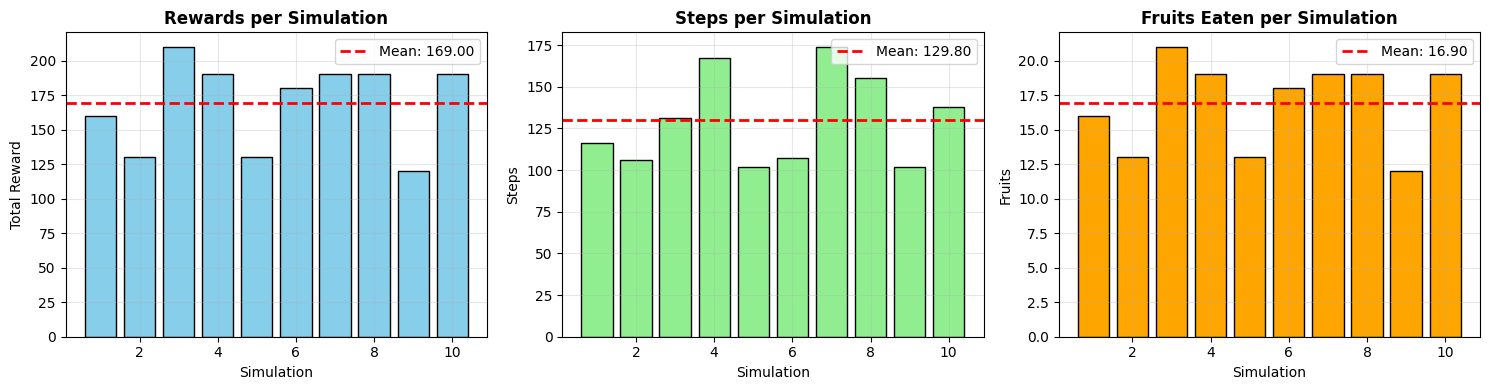


TESTING EPISODE 100
Loading model from: models/dqn_model_episode_140.keras

Simulation 1/10...
  Result: Reward=240.00, Steps=173, Fruits=24

Simulation 2/10...
  Result: Reward=220.00, Steps=139, Fruits=22

Simulation 3/10...
  Result: Reward=250.00, Steps=203, Fruits=25

Simulation 4/10...
  Result: Reward=90.00, Steps=56, Fruits=9

Simulation 5/10...
  Result: Reward=200.00, Steps=174, Fruits=20

Simulation 6/10...
  Result: Reward=150.00, Steps=121, Fruits=15

Simulation 7/10...
  Result: Reward=310.00, Steps=318, Fruits=31

Simulation 8/10...
  Result: Reward=150.00, Steps=138, Fruits=15

Simulation 9/10...
  Result: Reward=180.00, Steps=199, Fruits=18

Simulation 10/10...
  Result: Reward=290.00, Steps=213, Fruits=29

TEST RESULTS SUMMARY
Number of Simulations: 10

REWARDS:
  Mean:   208.00 ± 64.47
  Min:    90.00
  Max:    310.00

STEPS (Game Length):
  Mean:   173.40 ± 65.55

FRUITS EATEN:
  Mean:   20.80
  Max:    31
  Total:  208


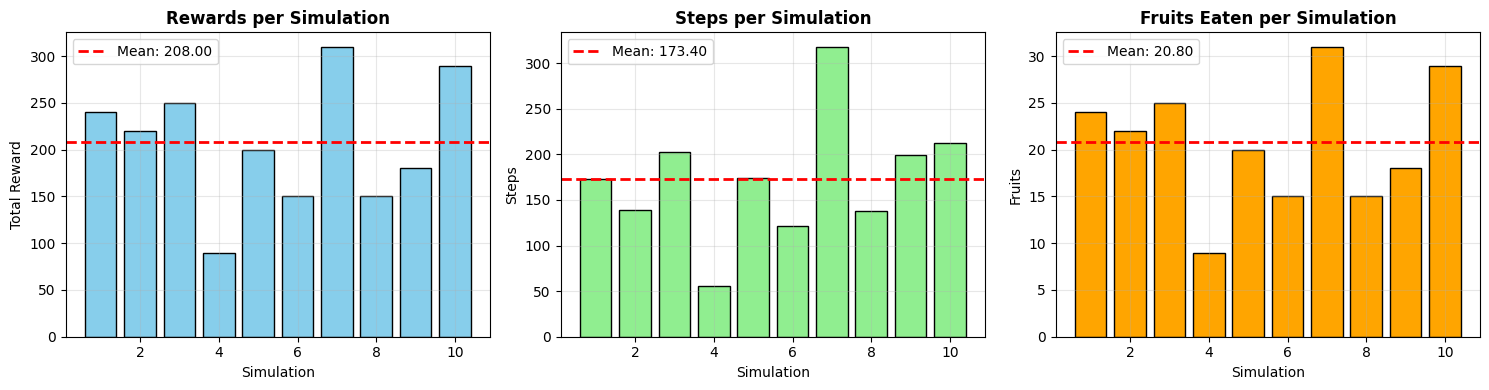

C:\Users\PC\AppData\Local\Temp\ipykernel_6752\3393790304.py:202: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp1 = ax4.boxplot(box_data_rewards, labels=[model1_name, model2_name],
C:\Users\PC\AppData\Local\Temp\ipykernel_6752\3393790304.py:213: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp2 = ax5.boxplot(box_data_steps, labels=[model1_name, model2_name],
C:\Users\PC\AppData\Local\Temp\ipykernel_6752\3393790304.py:224: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp3 = ax6.boxplot(box_data_fruits, labels=[model1_name, model2_name],
C:\Users\PC\AppData\Local\Temp\ipykernel_6752\3393790304.py:297: UserWarning: This

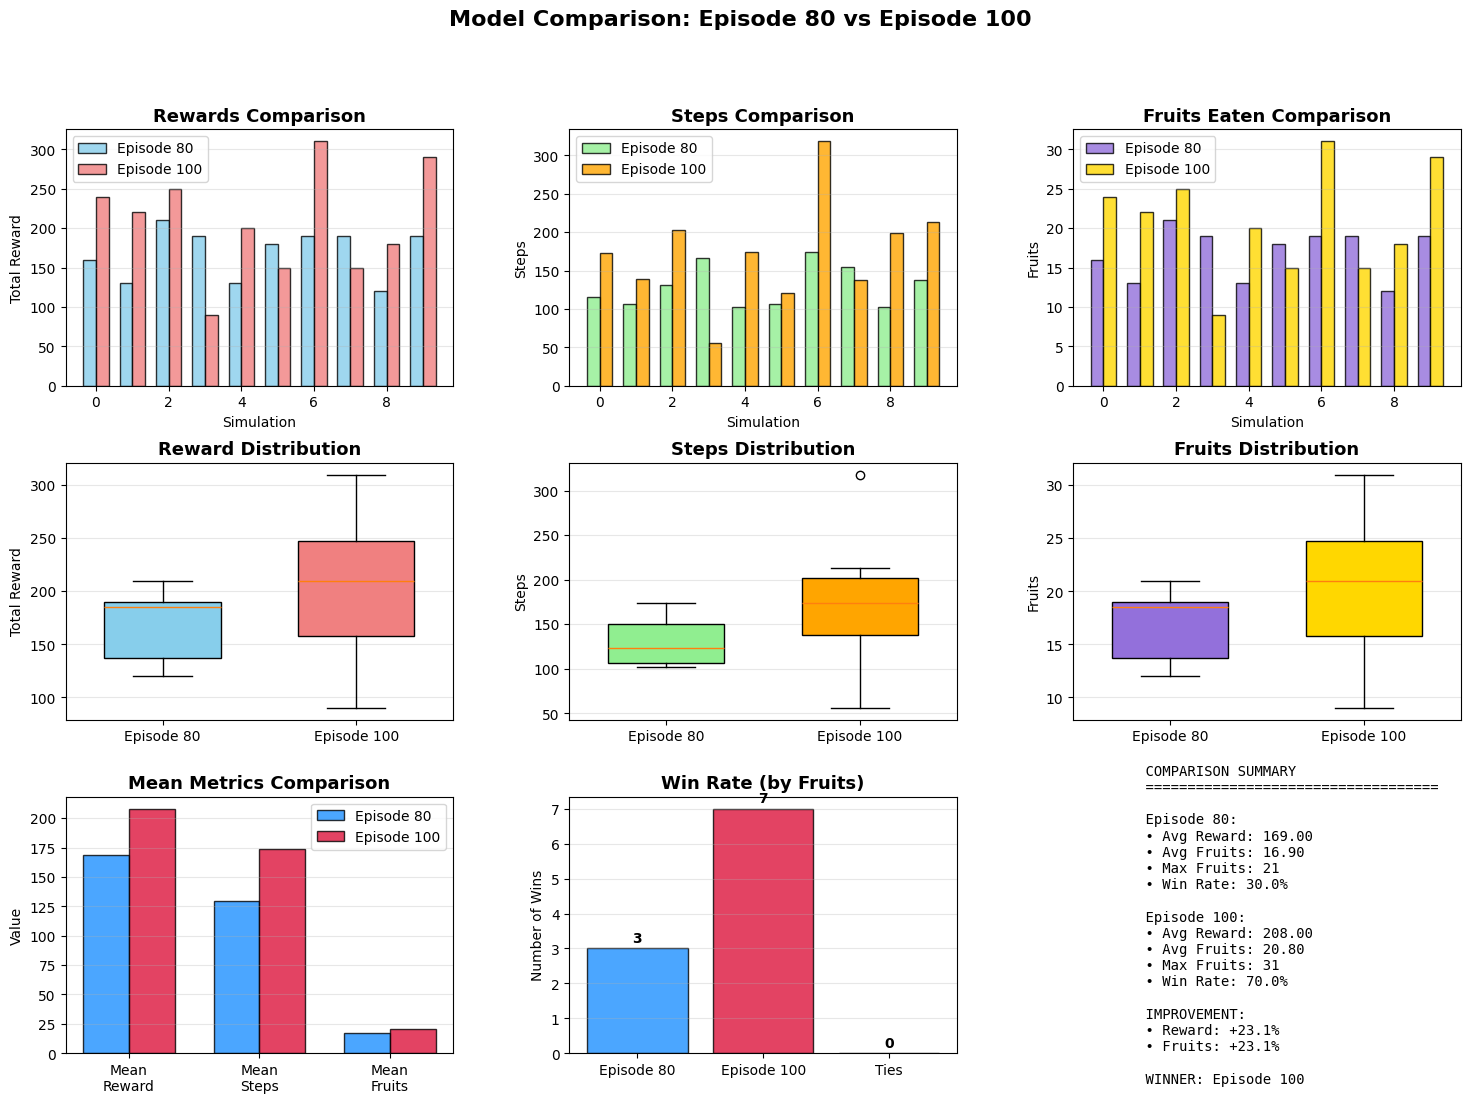

In [ ]:

comparison = compare_models(
    modelPath1="models/v2/dqn_model_episode_100.keras",
    modelPath2="models/dqn_model_episode_140.keras",
    numSimulations=10,
    model1Name="Episode 80",
    model2Name="Episode 100"
)